In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py


cuda = torch.device('cuda')
frame_size = 10
movie_ref = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("../data/static_ml20m.hdf5", "r")

In [15]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [16]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [17]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
    test_batch = prepare_batch(test_batch)
    losses = ddpg_update(test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
def plot(value_losses, policy_losses, test=True, cfg=False):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(len(value_losses))
        
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value_losses, label='train')
    plt.plot(test_losses[2], test_losses[0], label='test')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[2], test_losses[1], '-r', label='test')
    plt.legend()
    if cfg:
        plt.suptitle(cfg)
        
    plt.show()

In [19]:
from scipy.spatial import distance

def embed_show(embs):
    embs = embs.detach().cpu().numpy()
    similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
    similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

    fig = plt.figure(figsize=(16,10))

    ax = fig.add_subplot(121)
    cax = ax.matshow(similarity_matrix_cos)
    fig.colorbar(cax)
    ax.set_title('Cosine')

    ax = fig.add_subplot(122)
    cax = ax.matshow(similarity_matrix_euc)
    fig.colorbar(cax)
    ax.set_title('Euclidian')

    fig.suptitle('Action pairwise distances')
    fig.show()

In [20]:
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())

def ddpg_update(batch, gamma = 0.9, min_value=-np.inf, max_value=np.inf,
           soft_tau=1e-4, debug=False, learn=True, step=-1):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action).mean()
    
    next_action = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    debug_log_error('target_value ', target_value)
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    debug_log_error('value', value)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        global debug_test_gen_action
        debug_state = state
        debug_action = action 
        if not learn:
            debug_test_gen_action = gen_action
        else:
            debug_gen_action = gen_action

    if not learn:
        # used for testing
        [net.train() for net in nets]
        losses = [value_loss.item(), policy_loss.item()]
        return losses
    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
    if step > 0 and step % P_policy_step == 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()
        
        soft_update(value_net, target_value_net, soft_tau=P_soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=P_soft_tau)


    losses = [value_loss.item(), policy_loss.item()]
    
    return losses

In [21]:
# === ddpg settings ===
P_gamma = 0.99
P_min_value=-10
P_max_value=10
P_soft_tau=0.1
P_policy_lr = 1e-5
P_value_lr  = 1e-5
P_milestones = [1800]
P_policy_step = 3

P_cfg = {'gamma': P_gamma, 'min_v': P_min_value, 'max_v':P_max_value,
        'stau': P_soft_tau, 'policy_lr': P_policy_lr, 'value_lr': P_value_lr}
# === end ===

In [22]:
value_net  = Critic(1290, 128, 256).to(cuda)
policy_net = Actor(1290, 128, 256).to(cuda)

#value_net.load_state_dict(torch.load('../models/ddpg_sm_value.pt'))
#policy_net.load_state_dict(torch.load('../models/ddpg_sm_policy.pt'))

target_value_net = Critic(1290, 128, 256).to(cuda)
target_policy_net = Actor(1290, 128, 256).to(cuda)

target_policy_net.eval()
target_value_net.eval()

nets =[value_net, policy_net]

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

value_optimizer = optim.Adam(value_net.parameters(), lr=P_policy_lr, weight_decay=1e-2)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=P_value_lr, weight_decay=1e-2)

value_scheduler = optim.lr_scheduler.MultiStepLR(value_optimizer,  milestones=P_milestones)
#policy_scheduler = optim.lr_scheduler.MultiStepLR(policy_optimizer, milestones=P_milestones)

# todo unify
debug_state = None
debug_action = None
debug_gen_action = None
debug_test_gen_action = None
debug_target_value = []

debug_dict = {'error': {}}

In [23]:
value_losses = []
policy_losses = []
test_losses = [[], [], []]

step = 1

n_epochs = 100
batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

step 1860


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


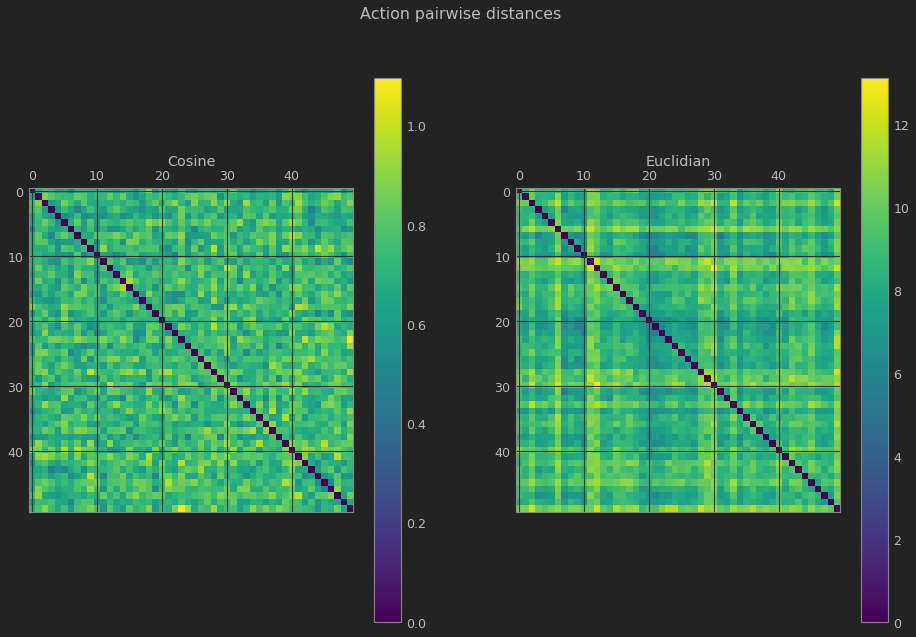

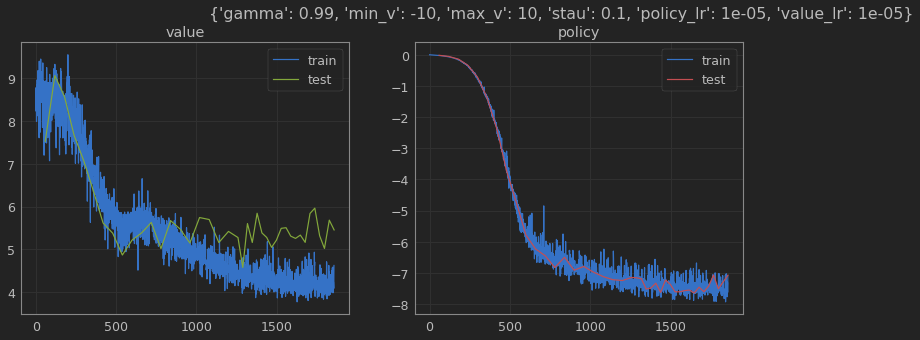

KeyboardInterrupt: 

In [44]:
def prepare_batch(batch):
    
    movies, ratings, done = batch
    movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
    movies_tensor = torch.stack([torch.stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    batch_size = done.size(0)
    
    state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1), ratings[:, :-1]], 1)
    next_state = torch.cat([movies_tensor[:, 1:, :].view(batch_size, -1), ratings[:, 1:]], 1)
    action = movies_tensor[:, -1]
    reward = ratings[:, -1]
    
    return [i.to(cuda) for i in [state, action, reward, next_state, done]]

# --- config ---
DEBUG = True

batch = []
plot_every = 30
min_policy_state_dict = None
min_policy_loss = 1
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
        batch = prepare_batch(batch)
        loss = ddpg_update(batch, debug=DEBUG, gamma = P_gamma, min_value=P_min_value,
                           max_value=P_max_value, soft_tau=P_soft_tau, step=step)
        
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        
        #if loss[1] < min_policy_loss and step > 1000:
            # note doen't change the target network
            #min_policy_loss = loss[1] 
            #min_policy_state_dict = policy_net.state_dict()
            
        #if step in P_milestones:
            #policy_net.load_state_dict(min_policy_state_dict)
            
        
        value_scheduler.step()
        # policy_scheduler.step()
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            #if debug_test_gen_action is not None:
            #    embed_show(debug_test_gen_action[:50])
            embed_show(debug_gen_action[:50])
            plot(value_losses, policy_losses, cfg=P_cfg)
            
    batch_bar.refresh()

# Debug info

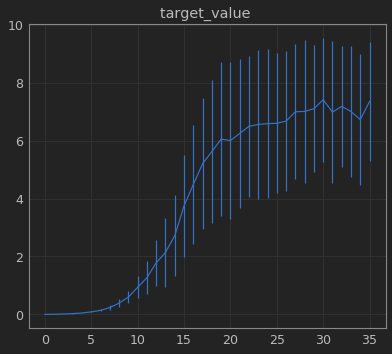

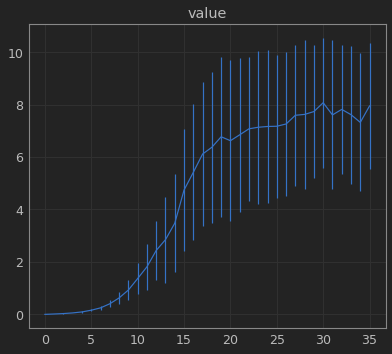

In [25]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

In [26]:
debug_gen_action[3]

tensor([ 0.3604, -0.0448, -0.2388,  0.0212,  0.3057, -0.0327, -0.0994,  0.7509,
         0.2702,  0.3336,  0.6816, -0.5902, -0.3097, -0.8898, -0.1238, -0.3845,
        -0.3493,  0.8526,  0.3726, -0.8047,  0.1438,  0.2537, -1.1006,  0.2520,
         0.3119,  0.4547,  0.6423, -0.5749, -0.3076,  0.3270, -0.7505, -0.1916,
         0.7275, -0.7637, -0.1739,  0.3414,  0.5068, -0.0776, -0.5027, -0.6112,
         0.4029, -0.3042, -0.6334,  0.3044, -0.1094, -0.6695, -0.3717,  0.0282,
         0.2025, -0.8308, -0.0921,  0.2156,  0.2066, -0.3561,  0.0160, -0.7112,
        -0.1768,  1.0648,  0.5157, -0.0245,  0.1506, -0.8261,  0.0583,  0.3162,
         0.6456, -0.3630,  1.1661, -0.6155, -0.1283, -0.0910,  0.9209, -0.2021,
        -0.3491,  0.1161,  0.1985,  0.0920, -0.4774, -0.8478, -0.9570, -0.2711,
        -0.5594, -0.3446, -0.5715, -0.9779, -0.6801,  0.3482, -0.0604, -0.3360,
        -0.4496, -0.0660, -0.4735, -0.1155,  0.0359, -0.1408,  0.1464, -0.0027,
         0.5636, -0.3923, -0.0481, -0.09

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


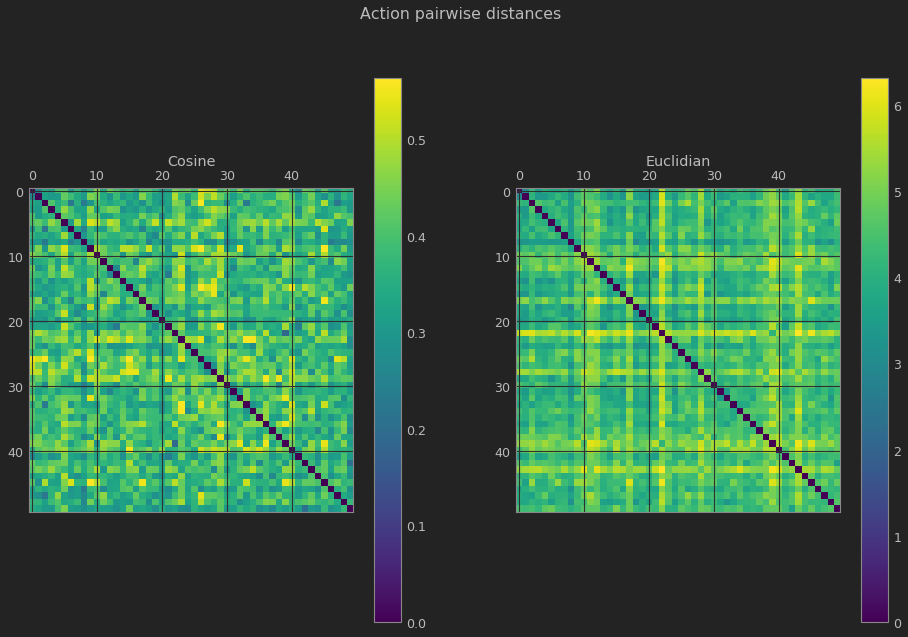

In [27]:
embed_show(debug_test_gen_action[:50])

# Reconstruction error

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


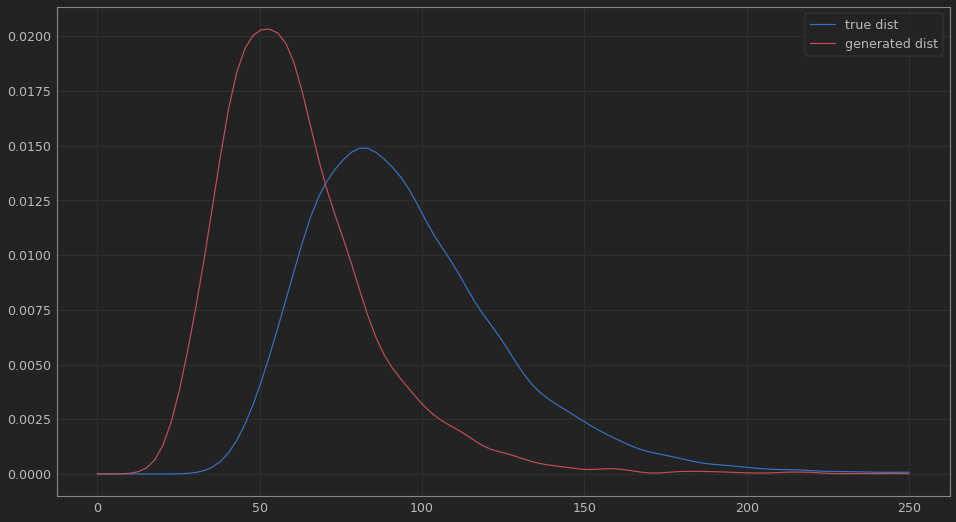

In [43]:

from scipy.special import kl_div
gen_actions = debug_gen_action
gen_test_actions = debug_test_gen_action
true_actions = np.stack([movie_ref[i] for i in movie_ref])


class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()
    
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../models/anomaly.pt'))
ad.eval()

from scipy import stats


true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()
gen_test_scores =ad.rec_error(torch.tensor(gen_test_actions).to(cuda).float()) \
                                                            .detach().cpu().numpy() 

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
gen_test_kernel = stats.gaussian_kde(gen_test_scores)

x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
probs_gen_test = gen_test_kernel(x)
plt.figure(figsize=(16, 9))
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
# plt.plot(x, probs_gen_test, '-w', label='generated test dist')
plt.legend()
plt.show()